In [1]:
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
LW=5 # linewidth
MS=10 # markersize

from dataclasses import dataclass

# Exploiting recursivity in linear regression
Alex Gorodetsky, November 2020, Updated March 2024

In this notebook we demonstrate the idea that recursive solutions are equivalent to batch solutions after all data is obtained (when no decisions or changes are made between data updates). We also highlight the process by which one would implement them. The example is on linear regression, there is no dynamics. However, we will later apply the recursion strategy in the dynamical systems context.

We begin with the solution to linear-Gaussian inverse problems

In [3]:
def linear_update_step(data: np.ndarray,
                       A: np.ndarray,
                       prior_mean: np.ndarray,
                       prior_cov: np.ndarray,
                       noise_cov: np.ndarray):
    """Linear Gaussian Inverse Problem.

    Inputs
    ------
    data: (N) array of data
    A: (N, d) linear model
    prior_mean: (d) prior mean
    prior_cov: (d, d) prior covariance
    noise_cov : (N, N) noise covariance matrix

    Returns
    -------
    update_mean: (d, ) updated mean
    update_cov: (d, d) updated covariance

    """
    delta = data - np.dot(A, prior_mean)
    S = np.dot(A, np.dot(prior_cov, A.T)) + noise_cov
    update_mean = prior_mean + np.dot(prior_cov, np.dot(A.T, np.linalg.solve(S, delta)))
    ch = np.dot(prior_cov, A.T)
    update_cov = prior_cov - np.dot(ch, np.linalg.solve(S, ch.T))
    return update_mean, update_cov

Next we generate data. We are working with linear models

$$Y_k = \theta_1 + \theta_2 t_k + \eta$$


In [4]:
@dataclass
class Dataset:
    times: np.ndarray
    data: np.ndarray
    times_for_plotting: np.ndarray
    true_vals_at_plotting: np.ndarray

def generate_data(num_data, maxtime=1.0, theta1=1.0, theta2=0.7, noise_std=1e-1) -> Dataset:
    """Generate data.

    Inputs
    ------
    num_data : number of smaples
    maxtime: maximum time step
    theta1: intercept parameter
    theta2: slope parameter
    noise_std: standard deviation of noise

    Returns
    -------
    t_k : times of the data
    y_data: values of the data
    t_plot : linearly space times, which we use for plotting
    y_true:  true linear model at t_plot
    """
    t_k = np.random.rand(num_data)*maxtime
    t_k = np.sort(t_k)
    y_data = theta1 + theta2*t_k + noise_std*np.random.randn(num_data)
    t_plot = np.linspace(0, maxtime, 1000)
    y_true = theta1 + theta2*t_plot
    return Dataset(t_k, y_data, t_plot, y_true)


dataset = generate_data(50)

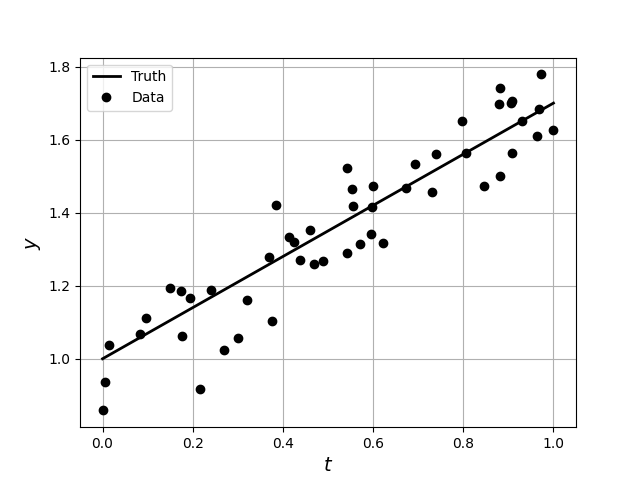

In [6]:
def get_fig(fignum):
    fig = plt.figure(fignum)
    plt.plot(dataset.times_for_plotting,
             dataset.true_vals_at_plotting,
             '-k', linewidth=2, label='Truth')
    plt.plot(dataset.times, dataset.data, 'ok',label='Data')
    plt.xlabel(r'$t$', fontsize=14)
    plt.ylabel(r'$y$', fontsize=14)
    plt.grid()
    return fig
plt.close(1)
fig = get_fig(1)
plt.legend()
plt.show()

Next we set up the prior mean (standard gaussian), compute the batch posterior and visualize everything

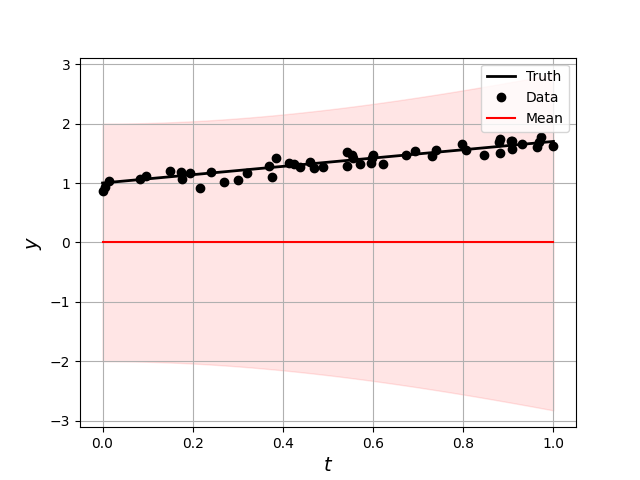

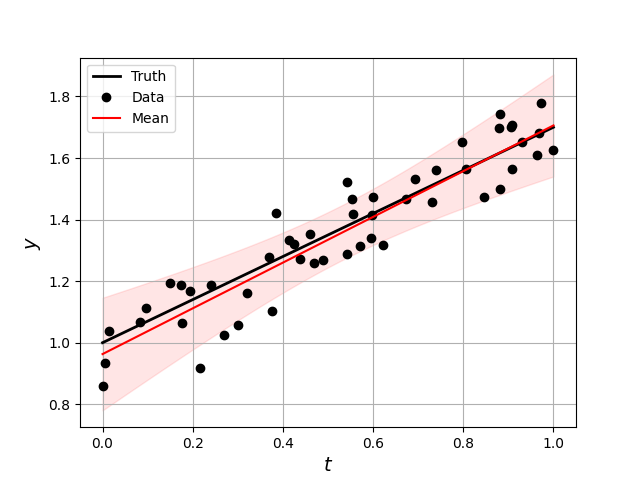

In [11]:
prior_mean = np.zeros(2)
prior_cov = 1*np.eye(2)
AP = np.ones((len(dataset.times_for_plotting), 2))
AP[:, 1] = dataset.times_for_plotting
prior_predict_mean = np.dot(AP, prior_mean)
prior_predict_std = np.sqrt(np.diag(np.dot(AP, np.dot(prior_cov, AP.T))))
plt.close(2)
fig=get_fig(2)
plt.plot(dataset.times_for_plotting,
         prior_predict_mean, 'r', label='Mean')
plt.fill_between(dataset.times_for_plotting,
                 prior_predict_mean - 2 * prior_predict_std,
                 prior_predict_mean + 2 * prior_predict_std,
                 color='red', alpha=0.1)
plt.legend()
plt.show()


At = np.ones((len(dataset.times), 2))
At[:, 1] = dataset.times
noise_cov = np.eye(len(dataset.times))*0.1
post_mean, post_cov = linear_update_step(dataset.data, At,
                                         prior_mean, prior_cov, noise_cov)
post_pred_mean = np.dot(AP, post_mean)
post_pred_std = np.sqrt(np.diag(np.dot(AP, np.dot(post_cov, AP.T))))
plt.close(3)
fig=get_fig(3)
plt.plot(dataset.times_for_plotting,
         post_pred_mean, 'r', label='Mean')
plt.fill_between(dataset.times_for_plotting,
                 post_pred_mean - 2 * post_pred_std,
                 post_pred_mean + 2 * post_pred_std,
                 color='red', alpha=0.1)
plt.legend()
plt.show()

Now we we will look at recursive processing of minibatches

[1.00630616 0.33969693]


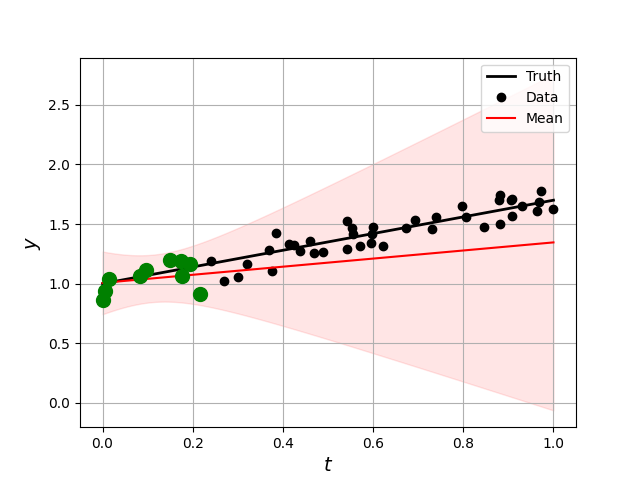

[0.98208837 0.63671877]


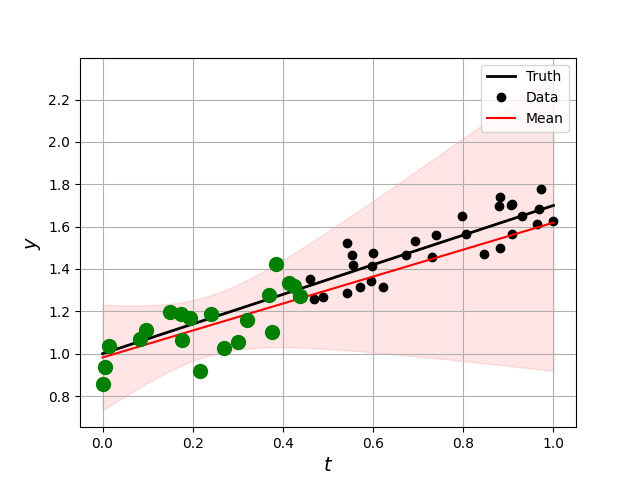

[0.97104461 0.71006937]


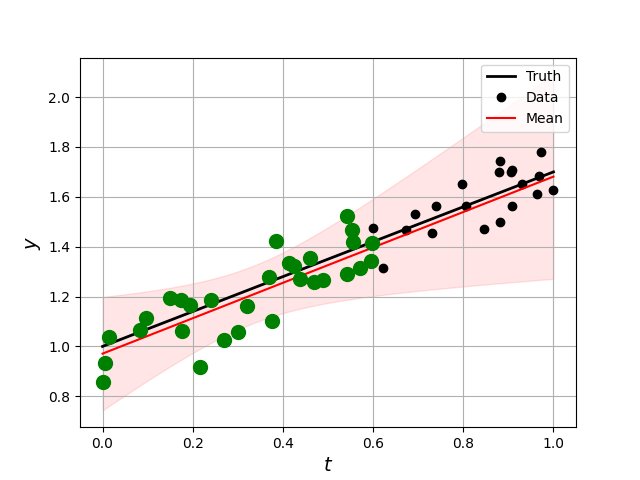

[0.96275536 0.74285957]


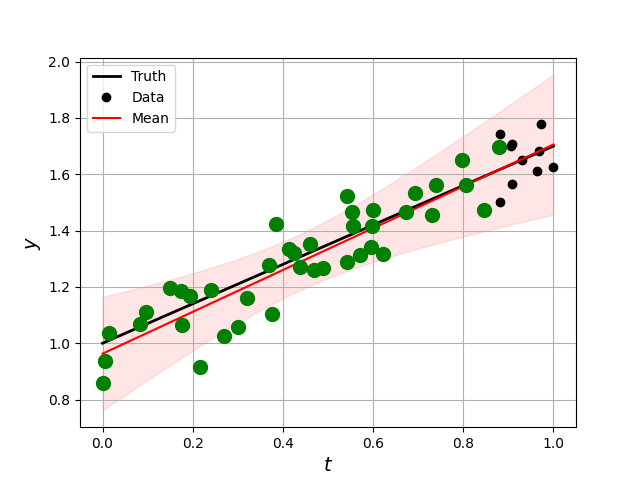

[0.96301756 0.74290393]


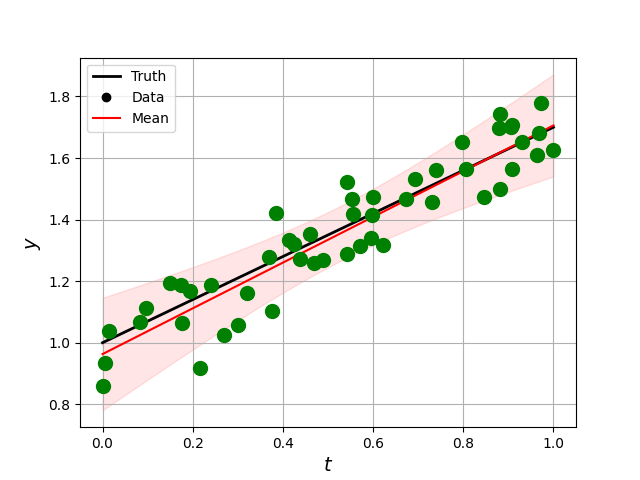

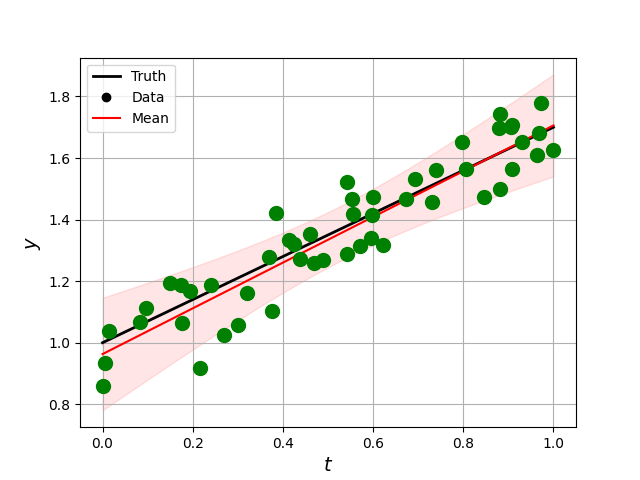

In [14]:
batch_size = 1
next_mean = prior_mean
next_cov = prior_cov
nrounds = int(len(dataset.times) / batch_size)
means = [[prior_mean[0], prior_mean[1]]]
fignum = 4
for ii in range(1,nrounds+1):

    ttrain = dataset.times[(ii-1)*batch_size:ii*batch_size]
    ytrain = dataset.data[(ii-1)*batch_size:ii*batch_size]
    At = np.ones((len(ttrain), 2))
    At[:, 1] = ttrain
    noise_cov = np.eye(len(ttrain))*0.1
    next_mean, next_cov = linear_update_step(ytrain, At, next_mean, next_cov, noise_cov)
    means.append([next_mean[0], next_mean[1]])
    if ii % 10 == 0 or ii == nrounds: # plot every 10
        print(next_mean)
        plt.close(fignum)
        fig=get_fig(fignum)
        fignum += 1
        ppred = np.dot(AP, next_mean)
        pstd = np.sqrt(np.diag(np.dot(AP, np.dot(next_cov, AP.T))))
        plt.plot(dataset.times_for_plotting, ppred, 'r', label='Mean')
        plt.fill_between(dataset.times_for_plotting,
                         ppred-2*pstd,
                         ppred+2*pstd, color='red', alpha=0.1)
        plt.plot(dataset.times[:ii*batch_size],
                 dataset.data[:ii*batch_size], 'go', ms=10)
        plt.legend()
        plt.show()
plt.show()

The final posterior matches exactly the batch final posterior, as expected. Lets look at the posterior mean of the parameters themselves.

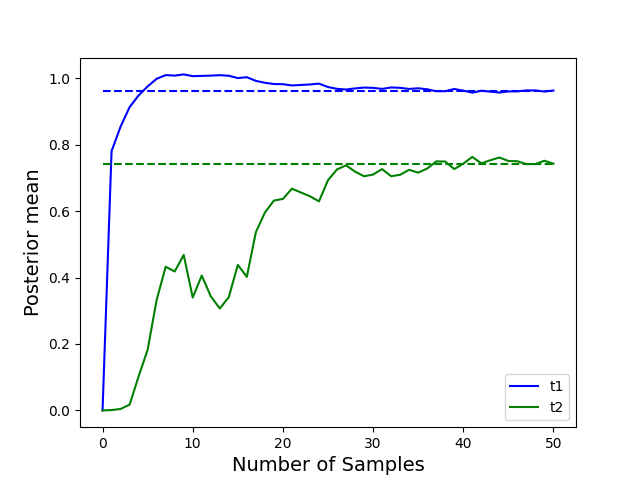

In [15]:
means = np.array(means)
plt.figure()
plt.plot(means[:, 0],'-b', label='t1')
plt.plot(post_mean[0]*np.ones((means.shape[0])), '--b')
plt.plot(means[:, 1],'-g', label='t2')
plt.plot(post_mean[1]*np.ones((means.shape[0])), '--g')
plt.xlabel("Number of Samples", fontsize=14)
plt.ylabel("Posterior mean", fontsize=14)
plt.legend()
plt.show()

The dotted lines indicate the posterior mean from the batch processing. The solid lines indicate the posterior mean after sequential updates, we see that they converge to the same value after processing all data.